## Shallow Fully-Connected NN for MNIST 

使用PyTorch进行网络搭建，显著提高了对于数字的分类成功率，发现loss在初期快速下降，后期在振荡中缓步下降，最终实现了达98%的成功率，并画出了confusion matrix

In [135]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [152]:
torch.__version__

'1.0.1'

### 数据与函数初始化 

In [136]:
# Check Device configuration
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [137]:
device

device(type='cuda')

In [144]:
# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [139]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [140]:
def accuracy(predicted,target):
    correct = 0
    #left = np.array(np.argmax(predicted,axis=0)).flatten()
    #right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(target)),len(np.unique(predicted))))
    for i in range(len(target)):
        if(predicted[i] == target[i]):
            correct+=1
        confusion_mat[target[i]][predicted[i]] =confusion_mat[target[i]][predicted[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

### 数据处理与训练 

In [141]:
# Fully connected neural network
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [142]:
model = FCNet(input_size, hidden_size, num_classes).to(device)

In [143]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

In [146]:
# Train the model
train_acc = 0
log_training_loss =[]
log_training_acc =[]
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        type(outputs)
        loss = criterion(outputs, labels)
        #outputs_cpu = outputs.cpu()
        #outputs = outputs.detach().numpy()
        #predict = np.argmax(outputs, axis=1)
        #train_acc,_  = accuracy(predict, labels.numpy())
        #log_training_acc.append(train_acc
        log_training_loss.append(loss.cpu().detach().numpy())
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch {}/{}, Step {}/{}, Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch 1/5, Step 100/600, Loss: 0.4424
Epoch 1/5, Step 200/600, Loss: 0.3329
Epoch 1/5, Step 300/600, Loss: 0.4417
Epoch 1/5, Step 400/600, Loss: 0.1256
Epoch 1/5, Step 500/600, Loss: 0.2139
Epoch 1/5, Step 600/600, Loss: 0.0799
Epoch 2/5, Step 100/600, Loss: 0.1744
Epoch 2/5, Step 200/600, Loss: 0.0698
Epoch 2/5, Step 300/600, Loss: 0.1432
Epoch 2/5, Step 400/600, Loss: 0.2274
Epoch 2/5, Step 500/600, Loss: 0.0712
Epoch 2/5, Step 600/600, Loss: 0.0568
Epoch 3/5, Step 100/600, Loss: 0.0774
Epoch 3/5, Step 200/600, Loss: 0.1016
Epoch 3/5, Step 300/600, Loss: 0.0627
Epoch 3/5, Step 400/600, Loss: 0.0932
Epoch 3/5, Step 500/600, Loss: 0.0616
Epoch 3/5, Step 600/600, Loss: 0.0481
Epoch 4/5, Step 100/600, Loss: 0.0529
Epoch 4/5, Step 200/600, Loss: 0.0766
Epoch 4/5, Step 300/600, Loss: 0.0240
Epoch 4/5, Step 400/600, Loss: 0.0352
Epoch 4/5, Step 500/600, Loss: 0.0571
Epoch 4/5, Step 600/600, Loss: 0.0816
Epoch 5/5, Step 100/600, Loss: 0.0360
Epoch 5/5, Step 200/600, Loss: 0.0170
Epoch 5/5, S

### 结果分析 

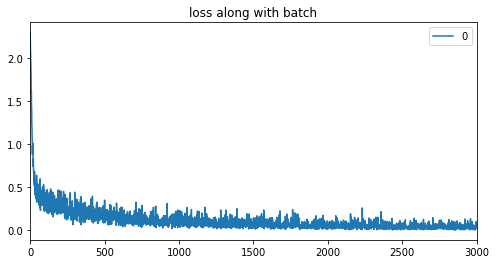

In [147]:
df = pd.DataFrame(log_training_loss)
ax = df.plot(figsize=(8,4))
ax.ticklabel_format(useOffset=False)
plt.title('loss along with batch')
plt.show(ax)

In [149]:
# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
conf_mat = np.zeros((10,10))
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        _, map_old = accuracy(predicted.cpu(),labels.cpu())
        conf_mat = map_old + conf_mat

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.02 %


In [150]:
conf_mat

,0,1,2,3,4,5,6,7,8,9
0,967.0,0.0,2.0,0.0,2.0,0.0,6.0,1.0,2.0,0.0
1,0.0,1125.0,3.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0
2,3.0,4.0,1000.0,8.0,2.0,0.0,2.0,4.0,9.0,0.0
3,0.0,0.0,2.0,998.0,0.0,2.0,0.0,2.0,3.0,3.0
4,0.0,0.0,2.0,1.0,972.0,0.0,3.0,1.0,0.0,3.0
5,1.0,0.0,0.0,4.0,2.0,876.0,4.0,0.0,3.0,2.0
6,2.0,3.0,0.0,1.0,2.0,4.0,944.0,0.0,2.0,0.0
7,1.0,4.0,9.0,6.0,2.0,0.0,0.0,999.0,1.0,6.0
8,3.0,0.0,2.0,9.0,6.0,2.0,3.0,2.0,943.0,4.0
9,1.0,3.0,0.0,7.0,11.0,4.0,1.0,3.0,1.0,978.0


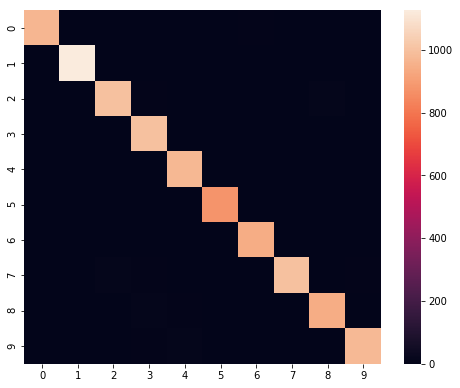

In [151]:
from IPython.core.pylabtools import figsize # import figsize
figsize(8, 6.5) # 设置 figsize
ax = sns.heatmap(conf_mat)